# 01_04_adjust_mansion_money_room / preview

`data/interim/01_04_adjust_mansion_money_room/train_mansion.parquet` に出力された `money_room_adjusted` が、元の `money_room` に対してどの倍率で補正されたかを確認する。未補正（倍率ちょうど 1.0）は本ノートでは集計対象外とする。


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.options.display.max_rows = 400
pd.options.display.max_columns = 200
sns.set_theme(style="whitegrid")


In [11]:
DATA_PATH = Path(
    "..",
    "..",
    "..",
    "..",
    "data",
    "interim",
    "01_04_adjust_mansion_money_room",
    "train_mansion.parquet",
).resolve()
print(f"Load: {DATA_PATH}")

df = pd.read_parquet(DATA_PATH)
print(df.shape)
df.head().T


Load: /Users/takamiya/work/0000_repos/signate_comp_2nd/data/interim/01_04_adjust_mansion_money_room/train_mansion.parquet
(198614, 141)


,0,1,2,3,4
data_id,4,12,16,17,34
target_ym,201901,201901,201901,201901,201901
money_room,18800000,16900000,16700000,14480000,8300000
building_id,134968,123843,101182,101182,79392
building_status,1,1,9,9,1
building_create_date,2014-06-27 19:24:12,2014-06-27 19:24:14,2014-06-27 19:24:16,2014-06-27 19:24:16,2014-06-27 21:12:09
building_modify_date,2025-09-15 02:49:23,2025-09-15 02:49:23,2025-09-15 02:49:23,2025-09-15 02:49:23,2025-09-15 01:17:12
building_type,1,1,1,1,1
building_name,ロイヤル知多寺本,ユーハウス知多寺本,リビオ巽が丘,リビオ巽が丘,シティーナ神立カメリア館B棟
homes_building_name,ロイヤル知多寺本,ユーハウス知多寺本,リビオ巽ヶ丘,リビオ巽ヶ丘,シティーナ神立 カメリア館B棟


In [12]:
valid_mask = (
    df["money_room"].notna()
    & df["money_room_adjusted"].notna()
    & (df["money_room"] > 0)
    & (df["money_room_adjusted"] > 0)
)
ratios = (df.loc[valid_mask, "money_room_adjusted"] / df.loc[valid_mask, "money_room"]).astype(float)
ratios = ratios[~np.isclose(ratios, 1.0)]

summary = (
    ratios.value_counts(dropna=False)
    .rename_axis("adjust_ratio")
    .reset_index(name="count")
    .assign(share=lambda d: d["count"] / len(df))
    .sort_values("adjust_ratio")
)
print(f"Valid rows: {valid_mask.sum():,}")
print(f"Corrected rows: {len(ratios):,}")
summary


Valid rows: 198,614
Corrected rows: 283


,adjust_ratio,count,share
1,0.1,34,0.000171
0,10.0,249,0.001254


In [13]:
PREFERRED_COLUMNS = [
    "money_room",
    "money_room_adjusted",
    "money_room_adjusted_ratio",
    "data_id",
    "full_address",
    "building_name",
    "unit_name",
    "target_ym",
    "room_count",
    "unit_house_area_adjusted",
    "unit_area",
    "unit_area_min",
    "unit_area_max",
]

df_ratio = df.loc[ratios.index].copy()
df_ratio["money_room_adjusted_ratio"] = (
    df_ratio["money_room_adjusted"] / df_ratio["money_room"]
).astype(float)

available_columns = [col for col in PREFERRED_COLUMNS if col in df_ratio.columns]
df_ratio = df_ratio[available_columns]

df_ratio.sort_values("money_room_adjusted_ratio").head(20)


,money_room,money_room_adjusted,money_room_adjusted_ratio,data_id,full_address,building_name,unit_name,target_ym,room_count,unit_house_area_adjusted,unit_area,unit_area_min,unit_area_max
198119,167000000,16700000,0.1,363080,東京都港区元麻布2丁目1-20,有栖川ナショナルコート,801,202207,3.0,36.0,109.269997,21.990000,36.000000
169293,148000000,14800000,0.1,309569,東京都港区赤坂9丁目4-1,パークコート赤坂檜町ザタワー,2304,202201,1.0,35.0,35.000000,NaN,NaN
169039,149500000,14950000,0.1,309185,愛知県名古屋市中区栄1丁目2-3,プラウドタワー名古屋栄,2906,202201,3.0,73.040001,91.500000,55.560001,73.040001
22929,84800000,8480000,0.1,32594,東京都台東区柳橋2丁目1-6,ザ・パークハウス浅草橋タワーレジデンス,1802,201901,3.0,24.530001,65.459999,24.440001,24.530001
23928,69900000,6990000,0.1,34049,神奈川県横浜市中区元町1丁目20,ストーク元町一番館,801,201901,3.0,29.299999,114.070000,27.010000,29.299999
25051,123000000,12300000,0.1,35907,東京都港区南青山2丁目27-28,グラン青山,1101,201901,1.0,17.549999,105.040001,16.690001,17.549999
29590,79800000,7980000,0.1,42954,神奈川県川崎市川崎区南町4-16,ナイスアーバンスピリッツ川崎駅南,901,201907,5.0,27.27,161.009995,17.100000,27.270000
50133,79900000,7990000,0.1,79127,神奈川県横浜市中区元町1丁目20,ストーク元町一番館,801,201907,3.0,29.299999,114.070000,27.010000,29.299999
78170,83000000,8300000,0.1,133322,神奈川県横浜市西区高島2丁目1-18,ロワール横濱レムナンツ,1301,202001,1.0,22.08,22.080000,20.040001,75.779999
77980,154000000,15400000,0.1,132922,東京都港区南青山6丁目7-1,タウンハウス南青山,401,202001,2.0,40.5,73.400002,35.770001,40.500000


In [14]:
df_ratio.sort_values("money_room_adjusted_ratio", ascending=False).head(20)


,money_room,money_room_adjusted,money_room_adjusted_ratio,data_id,full_address,building_name,unit_name,target_ym,room_count,unit_house_area_adjusted,unit_area,unit_area_min,unit_area_max
2954,7900000,79000000,10.0,3910,東京都八王子市小比企町1692-2,めじろ台ガーデンヒルズ,502,201901,NaN,68.04,NaN,68.040001,68.040001
116699,4900000,49000000,10.0,207615,東京都青梅市滝ノ上町1364-3,ライオンズマンション青梅,101,202101,3.0,52.270001,52.270001,48.270001,52.270001
114736,5900000,59000000,10.0,203715,神奈川県平塚市山下3丁目27-4,県公社平塚若宮ハイツ4号棟,503,202101,NaN,81.31,NaN,NaN,NaN
116629,4900000,49000000,10.0,207487,大阪府富田林市寺池台5丁目19-7,金剛グリーンハイツHA棟,508,202101,NaN,73.71,NaN,NaN,NaN
116664,6800000,68000000,10.0,207559,東京都青梅市新町9丁目2153-7,ダイアパレス青梅新町,907,202101,3.0,66.300003,66.300003,56.720001,74.360001
116665,7300000,73000000,10.0,207560,東京都青梅市新町9丁目2153-7,ダイアパレス青梅新町,714,202101,3.0,60.290001,60.290001,56.720001,74.360001
116670,4980000,49800000,10.0,207567,東京都青梅市千ヶ瀬町5丁目627-2,ホーユウパレス青梅,103,202101,2.0,45.84,45.840000,17.549999,40.169998
116672,7800000,78000000,10.0,207572,東京都青梅市友田町3丁目32-1,クリオ青梅壱番館,205,202101,3.0,69.760002,69.760002,46.549999,69.760002
116673,5000000,50000000,10.0,207576,東京都青梅市長淵2丁目515,MAC青梅コート,201,202101,3.0,52.470001,52.470001,55.889999,58.860001
116674,4980000,49800000,10.0,207577,東京都青梅市長淵2丁目515,MAC青梅コート,102,202101,3.0,61.47,66.449997,55.889999,58.860001


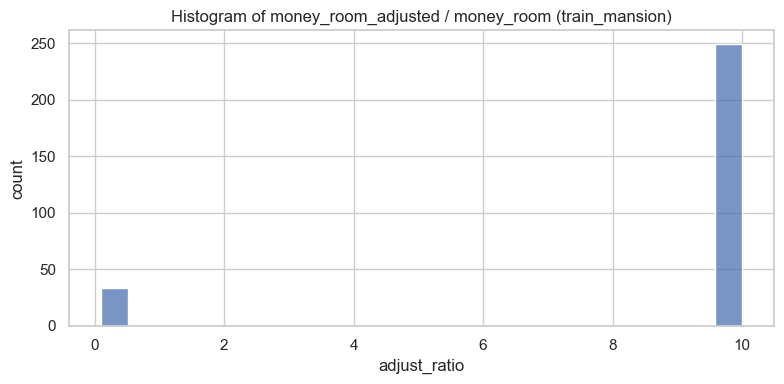

Value counts (top 10):


,adjust_ratio,count,share
1,0.1,34,0.000171
0,10.0,249,0.001254


In [15]:
if ratios.empty:
    print("No corrected rows to display.")
else:
    plt.figure(figsize=(8, 4))
    sns.histplot(ratios, bins=np.linspace(ratios.min(), ratios.max(), 25), kde=False)
    plt.title("Histogram of money_room_adjusted / money_room (train_mansion)")
    plt.xlabel("adjust_ratio")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    print("Value counts (top 10):")
    display(summary.head(10))
